In [1]:
import keras
import os
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from src.model import ESN
from src.utils import load_data
from src.model import simple_reservoir
from src.customs.custom_initializers import WattsStrogatzNX, InputMatrix



2024-08-11 17:37:11.814989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 17:37:11.833972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 17:37:11.834020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-11 17:37:11.845359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-11 17:37:12.612790: W tensorflow/compiler/tf

In [2]:
# Input matrix hyperparams

# Input scaling factor
min_sigma = 0.1
max_sigma = 5.0
step_sigma = 0.1

# Watts-Strogatz hyperparams

# degree
min_degree = 2
max_degree = 10
step_degree = 2

# spectral radius
min_spectral = 0.5
max_spectral = 1.5
step_spectral = 0.1

# rewiring prob
min_prob = 0.0
max_prob = 1.0
step_prob = 0.1

# ESN Cell

reservoir_units = 100

# leak rate
min_leak = 0.1
max_leak = 1
step_leak = 0.01


# Training

# regularization (log scale)

min_reg = 1e-9
max_reg = 1e-4
step_reg = 10

# This is for the training process

iterations = 5 # to make statistics take the mean
forecast_length = 2000 # the forecast length used to benchmark the model
train_length = 500 # ammount of points for training

max_trials = 200 # This is when not using hyperband

directory_name = "tuner_dir" # name of the folder that stores the hp exploratory process (lets you continue if broken)
project_name = "lorenz" # Change when needed

continue_where_leftoff = True # self-explanatory

overwrite = not continue_where_leftoff # This is the actual parameter used, setting the previous has more sense

## This is the banana, do not change

In [3]:
class MyHyperModel(kt.HyperModel):
    
    def __init__(self, input_shape, forecast_length=1000, data_path=None):
        self.input_shape = input_shape
        self.forecast_length = forecast_length
        self.data_path = data_path
    
    def build(self, hp):
        
        self.seed = hp.Int('seed', min_value=0, max_value=1000000)
        
        input_initializer = InputMatrix(sigma=hp.Float('input_scaling', min_value=min_sigma, max_value=max_sigma, step=step_sigma), seed=self.seed)
        
        recurrent_initializer = WattsStrogatzNX(
            degree=hp.Int('degree', min_value=min_degree, max_value=max_degree, step=step_degree),
            spectral_radius=hp.Float('spectral_radius', min_value=min_spectral, max_value=max_spectral, step=step_spectral),
            rewiring_p=hp.Float('rewiring_p', min_value=min_prob, max_value=max_prob, step=step_prob), seed=self.seed
        )
        
        bias_init = keras.initializers.random_uniform(seed=self.seed)
        
        
        reservoir = simple_reservoir(
                            #    units=hp.Int('units', min_value=1000, max_value=5000, step=100),
                               units=reservoir_units,
                               leak_rate=hp.Float('leak_rate', min_value=min_leak, max_value=max_leak, step=step_leak),
                               features=self.input_shape[-1],
                               input_reservoir_init=input_initializer,
                               reservoir_kernel_init=recurrent_initializer,
                               input_bias_init=bias_init)
        
        readout = keras.layers.Dense(self.input_shape[-1], activation="linear", name="readout")
        
        model = self.model = keras.Model(
                inputs=reservoir.inputs,
                outputs=readout(reservoir.output),
                name="ESN",
                )
        
        return model
        
    def fit(self, 
        hp, 
        model,
        iterations=5,
        **kwargs):
    
        results = []

        for i in range(iterations):
            if os.path.isdir(self.data_path):
                data_file = np.random.choice(os.listdir(self.data_path))
                data_file = os.path.join(self.data_path, data_file)
            else:
                data_file = self.data_path

            transient_data, train_data, train_target, ftransient, val_data, val_target = (
                load_data(data_file, train_length=train_length)
            )
            
                    
            
            print(f"Iteration {i + 1} of {iterations}")
            
            # Build the model again to include stochasticity in initialization
            model = self.build(hp)
            
            esn = ESN.from_model(model=model, seed=self.seed)

            train_loss = esn.train(
                transient_data,
                train_data,
                train_target,
                regularization = hp.Float('regularization', min_value=min_reg, max_value=max_reg, step=step_reg, sampling='log'),
            )

            predictions, states_over_time, cumulative_rmse, threshold_steps = esn.forecast(forecast_length=self.forecast_length, 
                                                                            forecast_transient_data=ftransient, 
                                                                            val_data=val_data, 
                                                                            val_target=val_target,
                                                                            internal_states=False,
                                                                            error_threshold=0.1)
            results.append(threshold_steps)

        mean_threshold_steps = np.mean(results)
        
        return mean_threshold_steps
        

## Loading the data to train

In [4]:
data_path = "./src/systems/data/Lorenz/" # change path to data csv


In [5]:
if os.path.isdir(data_path):
    data_file = np.random.choice(os.listdir(data_path))
    data_file = os.path.join(data_path, data_file)
else:
    data_file = data_path

transient_data, train_data, train_target, ftransient, val_data, val_target = (
    load_data(data_file, train_length=train_length)
)

## Define the model builder (no need to change)

In [6]:
hyper_model = MyHyperModel(input_shape=train_data.shape, forecast_length=forecast_length, data_path=data_path)

In [ ]:
# You can click this cell and then "Execute above cells" button (up arrow to the right)

## Choose type of heuristic to use (your call). Run only one of the following cells

#### The first two will run for at most `max_trials` times before stopping.

#### I recommend using BayesianOpt since hyperband has some troubles and random search is a no-brainer

### 1 Random search

In [ ]:
tuner = RandomSearch(objective=kt.Objective('steps', 'max'),
                        max_trials=max_trials,
                        directory=directory_name,
                        project_name=project_name,
                        overwrite=overwrite,
                        hypermodel=hyper_model,
                        max_retries_per_trial=3,
                        max_consecutive_failed_trials=5
)

### 2 Bayesian Optimization

In [10]:
tuner = BayesianOptimization(
    hypermodel=hyper_model,
    objective=kt.Objective("steps", "max"),
    max_trials=max_trials,
    directory=directory_name,
    project_name=project_name,
    overwrite=overwrite,
    max_retries_per_trial=3,
    max_consecutive_failed_trials=5,
)

Correcting spectral radius to 0.5
Spectral radius was previously 0.7030406594276428


### 3 Hyperband

In [8]:
tuner = Hyperband(
    hypermodel=hyper_model,
    objective=kt.Objective("steps", "max"),
    directory=directory_name,
    project_name=project_name,
    overwrite=overwrite,
    max_retries_per_trial=3,
    max_consecutive_failed_trials=5,
)

Correcting spectral radius to 0.5
Spectral radius was previously 0.7030406594276428


In [11]:
tuner.search(iterations=iterations)

Trial 20 Complete [00h 00m 01s]
steps: 4.0

Best steps So Far: 56.0
Total elapsed time: 00h 00m 24s


### Get the best hyperparams from the tuner

In [12]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

### Print the values of the best hp

In [13]:
best_hps.values

{'seed': 641757,
 'input_scaling': 0.30000000000000004,
 'degree': 6,
 'spectral_radius': 0.5,
 'rewiring_p': 0.0,
 'leak_rate': 0.82,
 'regularization': 1e-09}

### Create the best model using the best hp

In [15]:
model = MyHyperModel(input_shape=(train_data.shape), forecast_length=1000, data_path=data_path).build(best_hps)

Correcting spectral radius to 0.5
Spectral radius was previously 1.3397541046142578


### Instantiate the best ESN from the best model

In [16]:
esn = ESN.from_model(model=model, seed=best_hps.get('seed'))

esn.train(
    transient_data,
    train_data,
    train_target,
    regularization=best_hps.get('regularization')
)


Ensuring ESP...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Ensuring ESP took: 0.15 seconds.


Harvesting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Harvesting took: 0.14 seconds.


Calculating readout...
Calculating readout took: 0.0 seconds.

Training loss: 1.1809280522356858e-06

NRMSE: 7.915587775642052e-05



1.180928e-06

### Make your predictions

In [17]:
forecast_length = 1000
forecast,states,loss,threshold_steps = esn.forecast(
                                      forecast_length=forecast_length, 
                                      forecast_transient_data=ftransient, 
                                      val_data=val_data, 
                                      val_target=val_target,
                                      internal_states=False,
                                      error_threshold=0.1)

Output()

### Save your model if you want

In [ ]:
model.save("name_and_path")

### Plotting stuff

In [18]:
dt = 0.02
features = train_data.shape[-1]

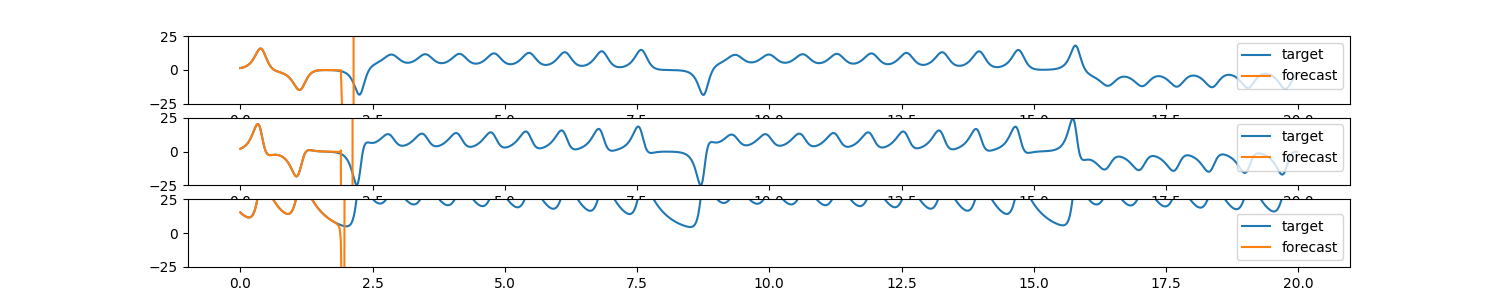

In [19]:
%matplotlib widget
# plot each forecast feature in a subplot, the shape of data is (batch, time, features)
fig, axs = plt.subplots(features, 1, figsize=(15, 3))
for i in range(features):
    axs[i].plot([j*dt for j in range(len(forecast[0, :forecast_length, i]))],val_target[0, :forecast_length, i], label='target')
    axs[i].plot([j*dt for j in range(len(forecast[0, :forecast_length, i]))], forecast[0, :forecast_length, i], label='forecast')
    axs[i].legend()
    # set y range to be from -25 to 25
    axs[i].set_ylim(-25, 25)